In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

import string

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler


# Inicializa o lemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')  # Para outras línguas, se necessário
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load the data
data = pd.read_csv('../data/labeled_data.csv')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
class PreproTweets(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.preprocess_text(text) for text in X]

    def preprocess_text(self, text):
        # print(text)
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\b\w{1,2}\b', '', text)  
        text = re.sub(r'[^\w\s]', '', text) 
        text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words)
        return text

# Exemplo de pipeline com pré-processamento e TF-IDF
pipeline_prepro_features = Pipeline([
    ('prepro', PreproTweets()),
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(n_components=10, random_state=42)),  # Adiciona NMF com 100 componentes
])

pipeline = Pipeline([
    ('prepro_features', pipeline_prepro_features),
    ('log_reg', LogisticRegression()),
])

texts, target = data['tweet'], data['class']

X, y = texts, target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# Treinando a pipeline com X e y
pipeline.fit(X_train, y_train)

c:\Users\gabri\Documents\classification-nlp\env\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Pipeline(steps=[('prepro_features',
                 Pipeline(steps=[('prepro', PreproTweets()),
                                 ('tfidf', TfidfVectorizer()),
                                 ('nmf',
                                  NMF(n_components=10, random_state=42))])),
                ('log_reg', LogisticRegression())])

In [6]:
# Fazendo previsões e avaliando o modelo
y_pred = pipeline.predict(X_test)

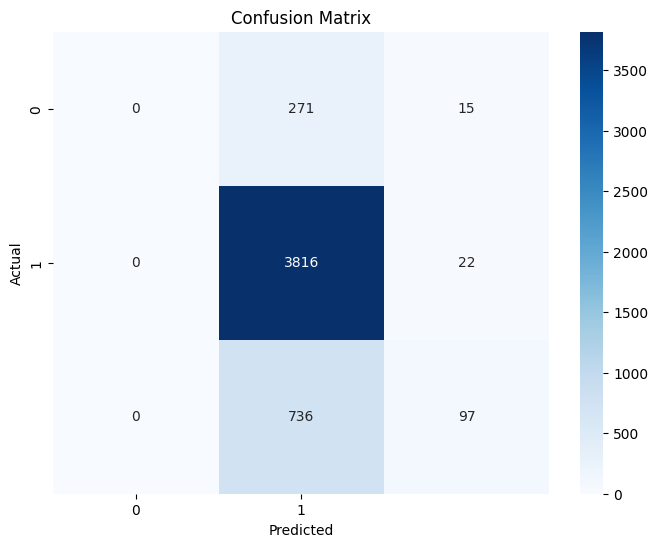

In [7]:
# confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# precision, recall e f1-score

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       286
           1       0.79      0.99      0.88      3838
           2       0.72      0.12      0.20       833

    accuracy                           0.79      4957
   macro avg       0.51      0.37      0.36      4957
weighted avg       0.73      0.79      0.72      4957



c:\Users\gabri\Documents\classification-nlp\env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gabri\Documents\classification-nlp\env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gabri\Documents\classification-nlp\env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

## Classes

In [11]:
pipeline_prepro_features = Pipeline([
    ('prepro', PreproTweets()),
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(n_components=10, random_state=42)),  # Adiciona NMF com 100 componentes
])

pipeline = Pipeline([
    ('prepro_features', pipeline_prepro_features),
    ('log_reg', LogisticRegression()),
])

texts, target = data['tweet'], data['class']

target = target.apply(lambda x: x//2)
texts_target = pd.concat([texts, target], axis=1)

In [17]:
target.value_counts(), target.value_counts().min(), y.value_counts()

(class
 0    20620
 1     4163
 Name: count, dtype: int64,
 np.int64(4163),
 class
 1    19190
 2     4163
 0     1430
 Name: count, dtype: int64)

In [20]:
down_sample = target.value_counts().min()
texts_target_undersampled = pd.concat([texts_target[texts_target['class'] == 0].sample(down_sample, random_state=42),
                                        texts_target[texts_target['class'] == 1]])

In [21]:
texts_target_undersampled['class'].value_counts()

class
0    4163
1    4163
Name: count, dtype: int64

In [22]:
X, y = texts_target_undersampled['tweet'], texts_target_undersampled['class']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
# Treinando a pipeline com X e y
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prepro_features',
                 Pipeline(steps=[('prepro', PreproTweets()),
                                 ('tfidf', TfidfVectorizer()),
                                 ('nmf',
                                  NMF(n_components=10, random_state=42))])),
                ('log_reg', LogisticRegression())])

In [25]:
# Fazendo previsões e avaliando o modelo
y_pred = pipeline.predict(X_test)

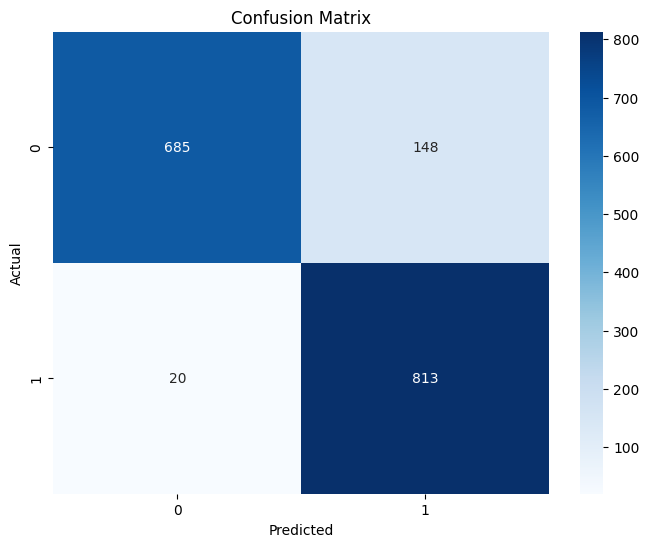

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       833
           1       0.85      0.98      0.91       833

    accuracy                           0.90      1666
   macro avg       0.91      0.90      0.90      1666
weighted avg       0.91      0.90      0.90      1666



## Visualizando os embeddings

In [28]:
components = pipeline[0].transform(X_train)

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(components)

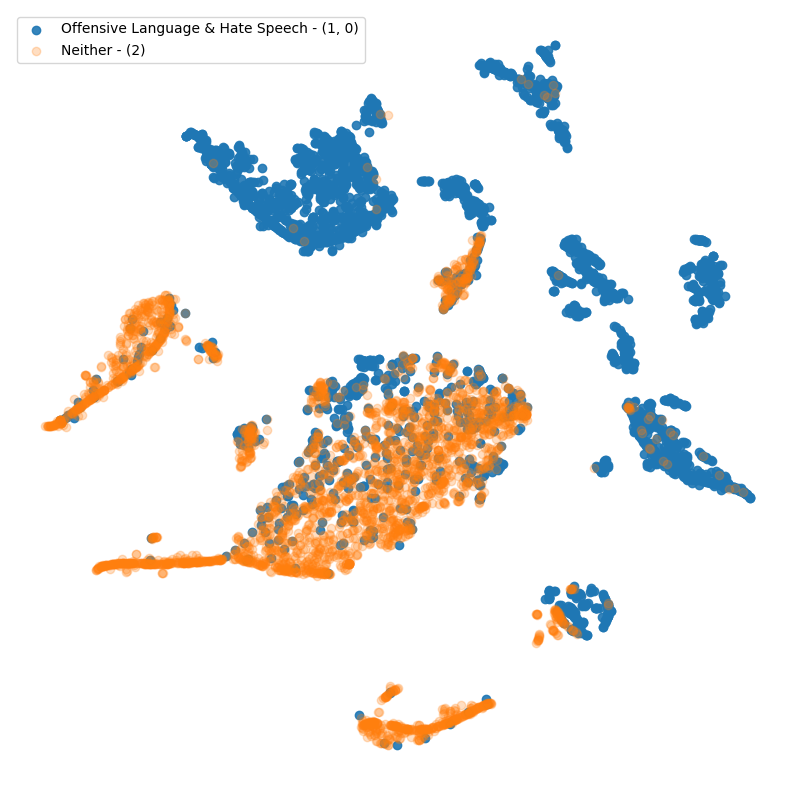

In [32]:
plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0][y_train == 0], 
            X_tsne[:, 1][y_train == 0], 
            label='Offensive Language & Hate Speech - (1, 0)', alpha=0.9)
plt.scatter(X_tsne[:, 0][y_train == 1], X_tsne[:, 1][y_train == 1], label='Neither - (2)', alpha=0.25)
plt.legend()
plt.axis('off')
plt.show()

## Palavras mais importantes para a Classificação

In [127]:
vectorizer_pipeline_1 = Pipeline([('prepro', PreproTweets()),
                                ('vectorizer', CountVectorizer(binary=True))])
vectorizer_pipeline_0 = Pipeline([('prepro', PreproTweets()),
                                  ('vectorizer', CountVectorizer(binary=True))])

In [134]:
X_count_1 = vectorizer_pipeline_1.fit_transform(X_train[y_train == 1]).sum(axis=0)
X_count_0 = vectorizer_pipeline_0.fit_transform(X_train[y_train == 0]).sum(axis=0)

In [145]:
X_count_1[0].shape, X_count_0[0].shape, vectorizer_pipeline_1['vectorizer'].get_feature_names_out().shape, vectorizer_pipeline_0['vectorizer'].get_feature_names_out().shape

((1, 11107), (1, 7969), (11107,), (7969,))

In [160]:
np.array(X_count_1)[0].argsort()[-5:]

array([ 1583, 10968,  5975,   925, 10081])

In [169]:
def print_words_count(count, vectorizer, k=5):
    words = vectorizer.get_feature_names_out()
    for i in count.argsort()[-k:]:
        print(words[i])
    print()

In [174]:
print_words_count(np.array(X_count_1)[0], vectorizer_pipeline_1['vectorizer'], k=20)

man
new
know
good
http
monkey
got
colored
ghetto
one
lol
get
amp
birds
yellow
charlie
yankees
like
bird
trash



In [176]:
print_words_count(np.array(X_count_0)[0], vectorizer_pipeline_0['vectorizer'], k=20)

bad
amp
one
love
fucking
niggas
know
lol
got
nigga
get
shit
fuck
ass
hoe
pussy
hoes
like
bitches
bitch



## Count Vectorizer - Topics

In [123]:
def print_words_in_topics(nmf, vectorizer):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(nmf.components_):
        print(f"Topic {idx}")
        for i in topic.argsort()[-5:]:
            print(words[i])
        print()
    print()

In [100]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_nmf_pipeline = Pipeline([('prepro', PreproTweets()),
                                    ('vectorizer', CountVectorizer(binary=True)),
                                    ('nmf', NMF(n_components=4))])

X_nmf = vectorizer_nmf_pipeline.fit_transform(X_train)

In [101]:
print_words_in_topics(vectorizer_nmf_pipeline['nmf'], vectorizer_nmf_pipeline['vectorizer'])

Topic 0
shit
nigga
fuck
ass
bitch

Topic 1
hoe
bird
pussy
look
like

Topic 2
good
man
get
talk
trash

Topic 3
shit
got
get
hoes
bitches


